In [1]:
import cv2
import numpy as np
from pandas import DataFrame, read_csv
from matplotlib import pyplot as plt
from shutil import copy2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Dense, Activation, Input, Conv2D, MaxPooling2D, Flatten,
                                     GlobalMaxPooling2D, LeakyReLU, concatenate, Dropout,
                                     AveragePooling2D, AveragePooling3D, MaxPooling3D)
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Nadam, Adamax
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet import MobileNet
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from os.path import isfile
from tqdm.notebook import tqdm
import itertools

In [2]:
SEED = 42
from numpy.random import seed
from tensorflow import random
seed(SEED)
random.set_seed(SEED)

In [3]:
y_filename='training_solutions_rev1.csv'
y = read_csv(y_filename, index_col=0)[['Class1.1','Class1.2','Class1.3']]

In [4]:
input_shape = (96,96)

In [5]:
model_DenseNet121 = DenseNet121(include_top=False, input_shape=(96,96,3))
model_Vgg16 = VGG16(include_top=False, input_shape=(96,96,3))

In [6]:
model_DenseNet121.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 48, 48, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 48, 48, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [7]:
model_Vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0     

In [8]:
def create_pretrained_model(input_shape):
    
    model = DenseNet121(include_top=False, input_shape=input_shape)
    output = model.get_layer('pool3_pool').output
    output = MaxPooling2D(pool_size=(3,3))(output)

    
#     model = VGG16(include_top=False, input_shape=input_shape)
#     output = model.layers[-1].output
#     output = AveragePooling2D(pool_size=(3,3))(output)
    
    output = Flatten()(output)
    
    model = Model(model.input, output)
    
    #model.trainable = False
    for layer in model.layers:
        layer.trainable = False
    return model

In [9]:
model = create_pretrained_model((input_shape[0],input_shape[1],3))

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 102, 102, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 48, 48, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 48, 48, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [11]:
train_datagen = ImageDataGenerator(rotation_range=180, zoom_range=0.1, horizontal_flip=True,
                                   vertical_flip=True)
train_generator = train_datagen.flow_from_directory(
        './train',
        target_size=input_shape,
        batch_size=50,
        class_mode='categorical',
        shuffle=False,
        seed=SEED)

Found 43104 images belonging to 3 classes.


In [12]:
valid_datagen = ImageDataGenerator()
valid_generator = valid_datagen.flow_from_directory(
        './test',
        target_size=input_shape,
        batch_size=50,
        class_mode='categorical',
        shuffle=False,
        seed=SEED)

Found 18474 images belonging to 3 classes.


In [13]:
def get_highlvl_features(model, datagen, multiplier=1):
    filenames = datagen.filenames
    nb_samples = len(filenames)
    
    batches = 0
    
    y_list = []
    feature_list = [] 
    
    for batch in tqdm(range(multiplier * (datagen.samples // datagen.batch_size))):
        x_batch, y_batch = datagen.next()
        y_batch_pred = model.predict(x_batch)
        
        feature_list.append(y_batch_pred)
        y_list.append(y_batch)

    highlvl_features = np.concatenate(feature_list)
    y = np.concatenate(y_list)
#     highlvl_features = model.predict_generator(datagen, nb_samples*multiplier)
    
#     bacth_size_old = datagen.batch_size
#     datagen.batch_size = nb_samples
#     y = train_generator.next()[1]
#     y = np.tile(y,multiplier)
#     datagen.batch_size = bacth_size_old
    
    return highlvl_features, y

In [14]:
features_train_file = 'TL-features-train.npy'
features_valid_file = 'TL-features-valid.npy'
y_train_file = 'TL-y-train.npy'
y_valid_file = 'TL-y-valid.npy'

In [15]:


if isfile(features_train_file):
    features_train = np.load(features_train_file, allow_pickle=True)
    features_valid = np.load(features_valid_file, allow_pickle=True)
    y_train = np.load(y_train_file, allow_pickle=True)
    y_valid = np.load(y_valid_file, allow_pickle=True)
else:
    features_train, y_train = get_highlvl_features(model, train_generator, 4)
    features_valid, y_valid = get_highlvl_features(model, valid_generator)
    
    np.save(features_train_file, features_train, allow_pickle=True)
    np.save(features_valid_file, features_valid, allow_pickle=True)
    np.save(y_train_file, y_train, allow_pickle=True)
    np.save(y_valid_file, y_valid, allow_pickle=True)

In [16]:
def create_toplvl_model(input_shape):
    return Sequential([
        Input(shape=input_shape),
        
        Dropout(0.1),
        Dense(128),
        Activation('relu'),
        Dropout(0.1),
        Dense(64),
        Activation('relu'),
        Dropout(0.1),
        Dense(32),
        Activation('relu'),
        Dropout(0.1),
        Dense(3),
        Activation('softmax')
])

In [17]:
features_train.shape, y_train.shape, features_valid.shape, y_valid.shape

((172262, 1024), (172262, 3), (18450, 1024), (18450, 3))

In [18]:
toplvl_input_shape = model.output_shape[1]
top_model = create_toplvl_model(toplvl_input_shape)
toplvl_input_shape

1024

In [19]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

loss='categorical_crossentropy'
LEARNING_RATE = 0.05
BATCH_SIZE = 50
EPOCHS = 50
                             
#model.compile(loss=loss, optimizer='adamax', metrics=[root_mean_squared_error])
top_model.compile(loss=loss, batch_size=BATCH_SIZE, optimizer='nadam', metrics=['acc',root_mean_squared_error])

In [20]:
history = top_model.fit(x=features_train, y=y_train, epochs=EPOCHS, validation_data=(features_valid, y_valid),
                    verbose=1)

Train on 172262 samples, validate on 18450 samples
Epoch 1/100
172262/172262 [==============================] - 20s 116us/sample - loss: 0.4767 - acc: 0.7790 - root_mean_squared_error: 0.3176 - val_loss: 0.4532 - val_acc: 0.7912 - val_root_mean_squared_error: 0.3088
Epoch 2/100
172262/172262 [==============================] - 18s 104us/sample - loss: 0.4443 - acc: 0.7980 - root_mean_squared_error: 0.3053 - val_loss: 0.4295 - val_acc: 0.8035 - val_root_mean_squared_error: 0.2995
Epoch 3/100
172262/172262 [==============================] - 17s 100us/sample - loss: 0.4336 - acc: 0.8020 - root_mean_squared_error: 0.3015 - val_loss: 0.4439 - val_acc: 0.8001 - val_root_mean_squared_error: 0.3027
Epoch 4/100
172262/172262 [==============================] - 17s 100us/sample - loss: 0.4285 - acc: 0.8048 - root_mean_squared_error: 0.2993 - val_loss: 0.4336 - val_acc: 0.8022 - val_root_mean_squared_error: 0.3001
Epoch 5/100
172262/172262 [==============================] - 18s 102us/sample - loss:

172262/172262 [==============================] - 18s 103us/sample - loss: 0.3895 - acc: 0.8248 - root_mean_squared_error: 0.2842 - val_loss: 0.4190 - val_acc: 0.8106 - val_root_mean_squared_error: 0.2940
Epoch 39/100
172262/172262 [==============================] - 18s 102us/sample - loss: 0.3887 - acc: 0.8250 - root_mean_squared_error: 0.2840 - val_loss: 0.4219 - val_acc: 0.8070 - val_root_mean_squared_error: 0.2964
Epoch 40/100
172262/172262 [==============================] - 18s 103us/sample - loss: 0.3883 - acc: 0.8244 - root_mean_squared_error: 0.2839 - val_loss: 0.4216 - val_acc: 0.8109 - val_root_mean_squared_error: 0.2938
Epoch 41/100
172262/172262 [==============================] - 18s 104us/sample - loss: 0.3880 - acc: 0.8241 - root_mean_squared_error: 0.2837 - val_loss: 0.4239 - val_acc: 0.8126 - val_root_mean_squared_error: 0.2941
Epoch 42/100
172262/172262 [==============================] - 18s 105us/sample - loss: 0.3885 - acc: 0.8244 - root_mean_squared_error: 0.2838 - v

Epoch 76/100
172262/172262 [==============================] - 17s 101us/sample - loss: 0.3813 - acc: 0.8283 - root_mean_squared_error: 0.2809 - val_loss: 0.4154 - val_acc: 0.8146 - val_root_mean_squared_error: 0.2928
Epoch 77/100
172262/172262 [==============================] - 17s 100us/sample - loss: 0.3807 - acc: 0.8278 - root_mean_squared_error: 0.2811 - val_loss: 0.4320 - val_acc: 0.8099 - val_root_mean_squared_error: 0.2963
Epoch 78/100
172262/172262 [==============================] - 17s 101us/sample - loss: 0.3812 - acc: 0.8279 - root_mean_squared_error: 0.2809 - val_loss: 0.4402 - val_acc: 0.8079 - val_root_mean_squared_error: 0.2982
Epoch 79/100
172262/172262 [==============================] - 17s 101us/sample - loss: 0.3799 - acc: 0.8294 - root_mean_squared_error: 0.2802 - val_loss: 0.4152 - val_acc: 0.8142 - val_root_mean_squared_error: 0.2915
Epoch 80/100
172262/172262 [==============================] - 17s 101us/sample - loss: 0.3813 - acc: 0.8288 - root_mean_squared_erro

In [24]:
def plot_history(history, metrics=['loss'], val=False, shape=None, logy=False):
    if not isinstance(logy, list):
        logy = [logy] * len(metrics)
    df = DataFrame(history.history)
    if shape is None:
        shape = (1,len(metrics))
    for i, metric in enumerate(metrics):
        cols = [metric]
        if val:
            cols.append('val_' + metric)
        ax = plt.subplot(shape[0],shape[1],i+1)
        df[cols].plot(ax=ax, logy=logy[i])
        plt.grid(True)
        plt.xlabel('epoch')
    plt.show()

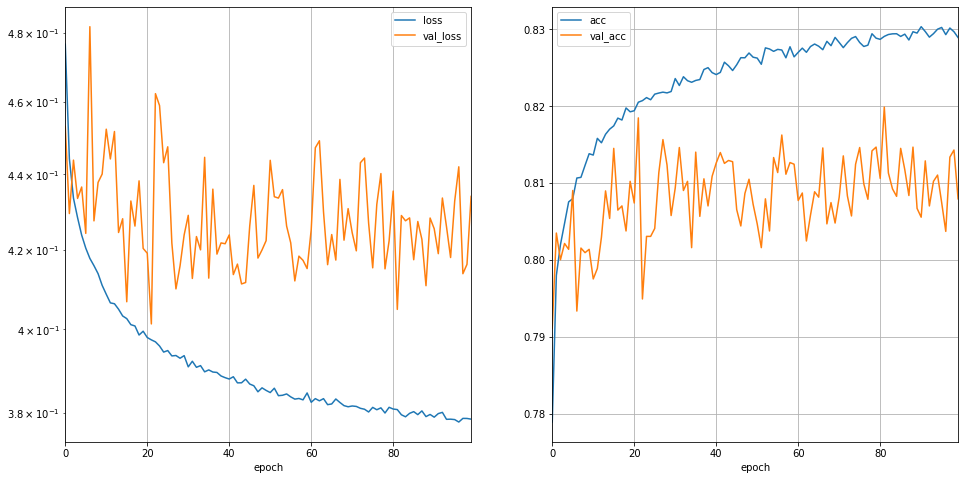

In [25]:
fig = plt.figure(figsize=(16, 8))
plot_history(history, metrics=['loss','acc'], val=True, logy=[True,False])

In [22]:
y_pred = top_model.predict(features_valid)

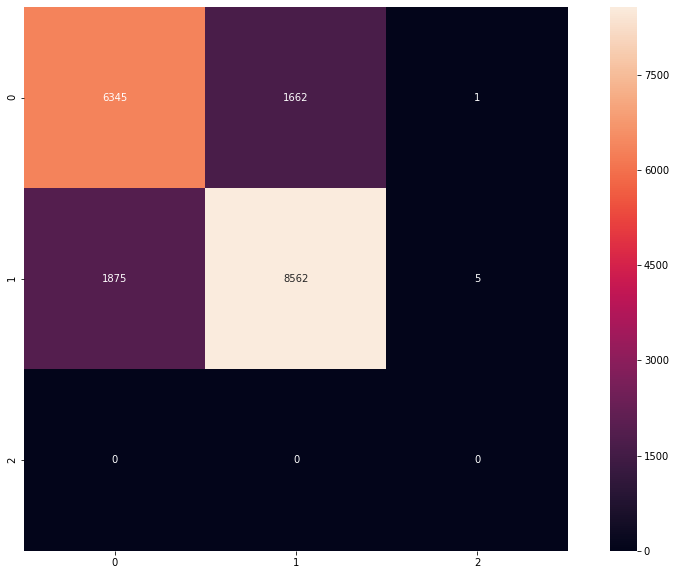

Accuracy= 0.8079674796747968


In [23]:
y_valid_class = y_valid.argmax(axis=1)
y_valid_pred_class = y_pred.argmax(axis=1)
conf_mat = confusion_matrix(y_valid_class, y_valid_pred_class)
plt.figure(figsize=(15,10))
sns.heatmap(conf_mat,square=True, annot=True, fmt='.0f')
plt.show()
print('Accuracy=', accuracy_score(y_valid_class, y_valid_pred_class))